# Hello Neighbour!
Kornpob Bhirombhakdi

## Problems & Significance
Knowing the distribution of the socioeconomic status, and the current consumer behaviour is always the biggest challenge in any business. These factors affect decision making, policy planning, and determine the odds of success. **"Hello Neighbour!" will be the solution.**

## Data
**Hello Neighbour!** analyzed the distribution of the socioeconomic status and consumer behaviour on US population by using data from a Census Block Group (CBG) survey, whih is the most granular level the US Census Bureau reports data on.

The dataset was acquired from Kaggle (https://www.kaggle.com/safegraph/census-block-group-american-community-survey-data/home), which included CBG-level data from the American Community Survey (2016) joined with the visit and consumer behavioural CBG-level data from SafeGraph (https://docs.safegraph.com/docs) conducting during 1st October--November 2018.

The size of dataset is about **8GB (unzipped)** containing more than 10 data tables, one GEOJSON file with the polygons for all CBGs, and some metadata files.

## Preliminaries

The dataset is very rich, and is high potential for providing insight to many questions. The following analysis presents some interesting features, in order to demonstrate what implications the data could bring.

In [1]:
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

### Where should the location of our new business be?

We might wonder about where the location of our new business should be to optimize the chance of being seen/visited. To answer this, knowing how the travel behaviour of the population is one of the keys, and the dataset can provide us this insight. Here is how the data looks like.

In [2]:
dat = dd.read_csv(r"C:\TDI\_data\safegraph_open_census_data\data\cbg_patterns.csv", dtype='str')
dat = dat[~dat['census_block_group'].isna()]
print(dat.columns)
print(dat.head(2))

Index(['census_block_group', 'date_range_start', 'date_range_end',
       'raw_visit_count', 'raw_visitor_count', 'visitor_home_cbgs',
       'visitor_work_cbgs', 'distance_from_home', 'related_same_day_brand',
       'related_same_month_brand', 'top_brands', 'popularity_by_hour',
       'popularity_by_day'],
      dtype='object')
  census_block_group date_range_start date_range_end raw_visit_count  \
0       010059508001       1538352000     1541030400           75122   
1       010090506011       1538352000     1541030400           95649   

  raw_visitor_count                                  visitor_home_cbgs  \
0             18314  {"010059501003":127,"010059509001":111,"010059...   
1             38942  {"010730113021":210,"010090506022":205,"010090...   

                                   visitor_work_cbgs distance_from_home  \
0  {"010059501003":109,"010810407002":62,"0108104...             194724   
1  {"010890111001":271,"010730045001":269,"010439...             120587   

 

Notice the **'distance_from_home'** column. It measured the median distance from home traveled to the CBG by visitors in meters. (Note: 1 meter ~ 6.21371e-4 mile)

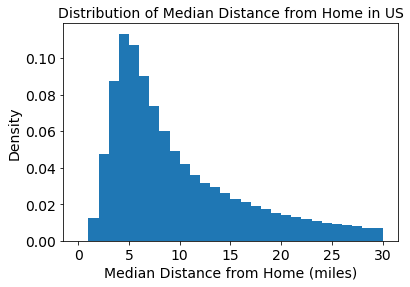

In [3]:
plt.figure()
plt.hist((dat['distance_from_home'].dropna().astype('float') * 6.21371e-4).compute()
         , bins=np.arange(31), density=True
        )
plt.title('Distribution of Median Distance from Home in US', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlabel('Median Distance from Home (miles)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [4]:
(dat['distance_from_home'].dropna().astype('float') * 6.21371e-4).describe().compute()

count    220518.000000
mean         21.818078
std          61.970527
min           0.438688
25%           5.404064
50%           9.238233
75%          19.671208
max        3913.298245
dtype: float64

The data implied that about 50% of the population travelled less than 9 miles in a day, with the mode at about 5 miles. Therefore, **setting up a new business within 9 miles radius from the residential area should be considered.** We note that this analysis aggregated every CBG as one population. Difference between sub-population such as rural compared to urban area would provide better insight, and can be analyzed from the dataset.

### When should the operation hours be?

In order to optimize the yields, some businesses might be flexible to design their own operation hours. Therefore, knowing how the area is populated during the week is valuable.

In [5]:
print(dat.columns)

Index(['census_block_group', 'date_range_start', 'date_range_end',
       'raw_visit_count', 'raw_visitor_count', 'visitor_home_cbgs',
       'visitor_work_cbgs', 'distance_from_home', 'related_same_day_brand',
       'related_same_month_brand', 'top_brands', 'popularity_by_hour',
       'popularity_by_day'],
      dtype='object')


We demonstrate how to answer this question by looking at **'popularity_by_day'** which measured the counts of visits on each day at the CBG.

In [6]:
x = dat['census_block_group'].compute()
x = x.str.extract('(..)(...)(......)(.)')
y = dat['popularity_by_day'].compute()
x['popularity_by_day'] = y
subdat = x.copy()
subdat.reset_index(drop=True,inplace=True)

# SS=36 for New York
# New York County/Manhattan 061, Kings County/Brooklyn 047, Queens County/Queens 081
ss = ['36']
ccc = ['061','047','081','003']
records = {}
for i in ss:
    for j in ccc:
        x = subdat[subdat[0]==i]
        x = x[x[1]==j]
        z = np.zeros(7)
        for k in x.index:
            try:
                y = x['popularity_by_day'].loc[k]
                z = z + np.array(list(ast.literal_eval(y).values()))
            except:
                print(y)
                print('Skip: {0}{1} {2}'.format(i,j,k))
        records[i+j] = z

{}
Skip: 36081 220675
{}
Skip: 36003 220633


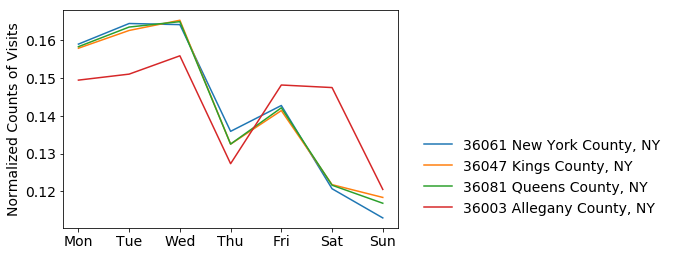

In [7]:
plt.figure()
x = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
lab = {'36061': 'New York County, NY', '36047': 'Kings County, NY', '36081': 'Queens County, NY', '36003': 'Allegany County, NY'}
for i in records.keys():
    plt.plot(x,records[i]/np.sum(records[i]),label='{} {}'.format(i,lab[i]))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Normalized Counts of Visits', fontsize=14)
plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=14, frameon=False)
plt.show()

The plot shows the trends of visits of 4 CBGs in NY: New York County, Kings County, Queens County, and Allegany County. The first three counties are considered urban, compared to the last one. As we can see, the visits were more frequent during the early of the week: Monday to Wednesday. Then, it plunged down on Thursday before climbing up again on Friday. **Saturday in Allegany tended to be busier than the urban areas**, while Sunday should be avoided for running a business in these areas.

### How is the competition in the area?

The analysis of competition in the market is important at every stage of a business. One valuable information we can get from the dataset is the counts of visits to various brands in each CBGs.

In [8]:
print(dat.columns)

Index(['census_block_group', 'date_range_start', 'date_range_end',
       'raw_visit_count', 'raw_visitor_count', 'visitor_home_cbgs',
       'visitor_work_cbgs', 'distance_from_home', 'related_same_day_brand',
       'related_same_month_brand', 'top_brands', 'popularity_by_hour',
       'popularity_by_day'],
      dtype='object')


In this analysis, we demonstrated with the **'top_brands'** visited during the time period.

In [9]:
x = dat['census_block_group'].compute()
x = x.str.extract('(..)(...)(......)(.)')
y = dat['top_brands'].compute()
x['top_brands'] = y
subdat = x.copy()

#39 = OH
ss = ['36','39']
records = {}
for i in ss:
    x = subdat[subdat[0]==i]
    y = []
    for j in x['top_brands']:
        z = ast.literal_eval(j)
        for k in z:
            y.append(k)
    y = pd.Series(y)
    records[i] = y.value_counts()

In [10]:
ranks = {}
for i in records.keys():
    x = records[i]
    x = x.to_frame()
    x.reset_index(drop=False,inplace=True)
    x.sort_values(by=[0],ascending=False,inplace=True)
    y = x.iloc[0:5]
#     z = {'index': 'Others', 0: np.sum(x[0].iloc[5:])}
#     z = pd.DataFrame([z])
#     y = pd.concat([y,z])
    y.reset_index(drop=True,inplace=True)
    y.columns = ['top_brands','counts']
    ranks[i] = y

In [11]:
a = {'36': 'NY', '39': 'OH'}
for i in ranks.keys():
    print(a[i])
    print(ranks[i])
    print('#######################')

NY
                            top_brands  counts
0  United States Postal Service (USPS)    1347
1                       Dunkin' Donuts    1229
2                               SUBWAY     791
3                               Sunoco     695
4                     Cricket Wireless     598
#######################
OH
                            top_brands  counts
0  United States Postal Service (USPS)     897
1                               SUBWAY     778
2                       Dollar General     706
3                   Marathon Petroleum     659
4                            mcdonalds     592
#######################


The analysis demonstrated the five most visited brands in NY and OH. Let's say, we would like to run **a donut shop**. Opening a new donut shop in NY would be more challenging than in OH.

### What is the income distribution?

Socioeconomic factors affect the choices of consumption. A successful business is the one which provides products matched with the demands given these underlying factors. Price, or the invisible hand, plays the most important role determining this, and every business must be precautious about.

There are several methods to estimate the price of a product. With the data we have, we can get insight in several aspects. One thing we want to know is how the income level is distributed.

In [12]:
dat2 = dd.read_csv(r"C:\TDI\_data\safegraph_open_census_data\data\cbg_b19.csv", dtype='str').compute()
colname = dd.read_csv(r"C:\TDI\_data\safegraph_open_census_data\metadata\cbg_field_descriptions.csv", dtype='str').compute()
print(dat2.columns)
print(dat2.head(2))
print('#################')
print(colname.columns)
print(colname.head(2))

Index(['census_block_group', 'B19001e1', 'B19001m1', 'B19001e2', 'B19001m2',
       'B19001e3', 'B19001m3', 'B19001e4', 'B19001m4', 'B19001e5',
       ...
       'B19313Ee1', 'B19313Em1', 'B19313Fe1', 'B19313Fm1', 'B19313Ge1',
       'B19313Gm1', 'B19313He1', 'B19313Hm1', 'B19313Ie1', 'B19313Im1'],
      dtype='object', length=401)
  census_block_group B19001e1 B19001m1 B19001e2 B19001m2 B19001e3 B19001m3  \
0       010010201001      284       53       24       29       33       25   
1       010010201002      456       64        8       10       15       24   

  B19001e4 B19001m4 B19001e5    ...    B19313Ee1 B19313Em1 B19313Fe1  \
0       23       22       25    ...          NaN       NaN       NaN   
1       14       22        5    ...          NaN       NaN       NaN   

  B19313Fm1 B19313Ge1 B19313Gm1 B19313He1 B19313Hm1 B19313Ie1 B19313Im1  
0       NaN       NaN       NaN  13071500   4351307       NaN       NaN  
1       NaN    932100    777912  35555700  10801102       NaN     

The above cell shows how the data look like. Note that we chose Table B19 because it related to the income, and the column description was provided in a separated file.

The data provided different measurements related to the income of participants in each CBG. Here, for demonstration we consider **the median household income in the past 12 months (in 2016 inflation-adjusted dollars).**

In [13]:
x = colname['field_full_name'].str.match(pat='MEDIAN HOUSEHOLD INCOME.+')
y = colname[x][['table_id','field_full_name']]
y.reset_index(drop=True,inplace=True)
y = y.iloc[0:2]
print(y['table_id'].unique())
print(y['field_full_name'].unique())

['B19013e1' 'B19013m1']
[ 'MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Estimate)'
 'MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS): Total: Households -- (Margin of Error)']


In [14]:
x = []
x = ['census_block_group']
for i in y['table_id'].unique():
    x.append(i)
z = dat2[x]
subdat = z.copy()
subdat.head(2)

,census_block_group,B19013e1,B19013m1
0,010010201001,NaN,NaN
1,010010201002,77813,11618


In [15]:
fips = {'36061': 'New York County, NY'
        , '36047': 'Kings County, NY'
        , '36081': 'Queens County, NY'
        , '36005': 'Bronx County, NY'
        , '36085': 'Richmond County, NY'}

In [16]:
x = subdat['census_block_group']
x = x.str.extract('(.....)(......)(.)')
subdat['fips'] = x[0]

In [17]:
y = list(fips.keys())
z = subdat[subdat['fips'].isin(y)]['B19013e1']

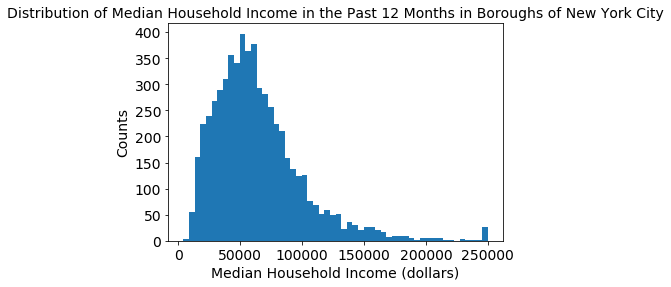

In [18]:
plt.figure()
plt.hist(z.dropna().astype('float')
         , bins='auto'
#          , density=True
        )
plt.title('Distribution of Median Household Income in the Past 12 Months in Boroughs of New York City', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xlabel('Median Household Income (dollars)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [19]:
z.astype('float').describe()

count      5856.000000
mean      64313.020663
std       36581.613565
min        4263.000000
25%       39375.000000
50%       57455.500000
75%       80682.750000
max      250001.000000
Name: B19013e1, dtype: float64

The data showed that the median of the income distribution was about $57k with the mode at about $50k. Therefore, if the business aims to target a large group of consumers in the Boroughs of New York City, **the target population with about $50-60k annual income would be appropriate.**

## Conclusion and Plan

The analysis here demonstrated how powerful the CBG survey can bring leverages to a business. Because the data were collected at the most granular level, the analysis for market segmentation can be done from the micro to macro levels. A lot of insight for decision making, policy implications, and strategic planning can be drawn.

For the future development, I plan to develop a friendly GUI deployed on a website, or as an application. The final product would provide freedom and flexibility for users to filter and visualize the results. For another part of this development, I plan to develop a model that can solve a problem like setting price of a product given underlying CBG characteristics.

## Youtube